In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, shift
from astropy import stats

1. generate random parabola going near centre (pick from rand gaussian) (need to explore parabola coefficient ranges)
2. get coords of centre point and two opposite points on parabola
3. Create gaussians around points (or other more asymmetric function, e.g. poisson...)
4. Angle of gaussians need to align with the parabola
5. Option for adding noise  
6. **Curve the gaussians along the parabola (find distance of each pixel away from curve and times...)**
7. Add random brightnesses to black hole and tails
8. Have x**3 option, i.e. oposite spiral direction for each tail
9. Inverse gaussian, i.e. bright in centre of tail, or bright at edge

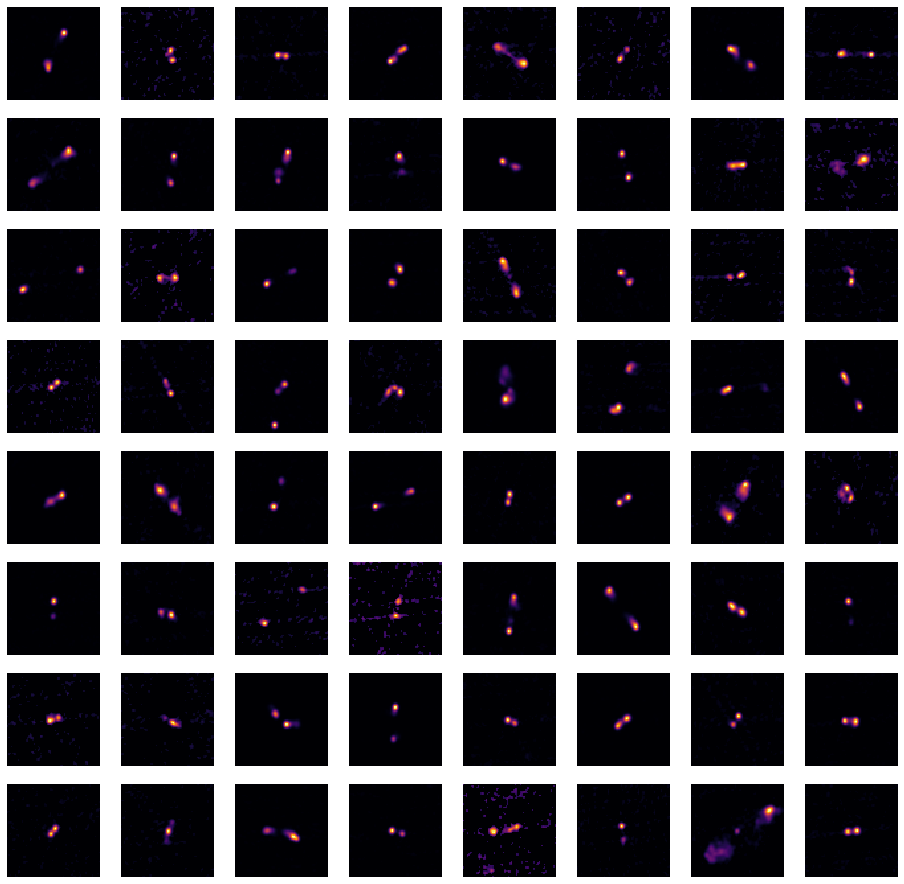

In [3]:
# Load sigma clipped data
images = np.load('../../Data/garon-combined.npy', allow_pickle=True)
images = images[0]
num_images, image_size, _ = images.shape

# Sigma clip
sigma = 2
for i in range(num_images):
    _, median, std = stats.sigma_clipped_stats(images[i], sigma=sigma)
    images[i][images[i] < median+sigma*std] = 0 #median+sigma*std

# Make images 56x56 to work with neural net models more easily
crop_size = 70
low_idx, upper_idx = image_size//2-crop_size//2, image_size//2+crop_size//2
images = images[:, low_idx:upper_idx, low_idx:upper_idx]

# Normalise images to [-1,1]
for i in range(num_images):
    images[i] = 2*(images[i]-np.min(images[i]))/np.ptp(images[i])-1
    
# Plot data
fig = plt.figure(figsize=(16,16))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(images[i,:,:], cmap='inferno')
    plt.axis('off')
plt.show()

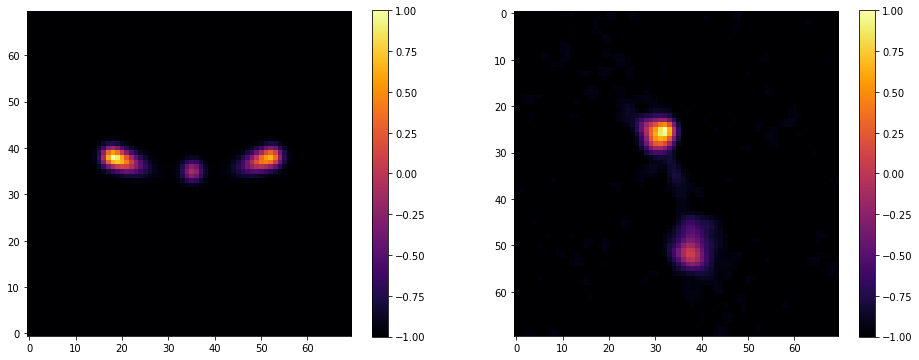

In [12]:
def add_gauss(im, mu_x, mu_y, sigma_x, sigma_y, theta, A):
    x, y = np.meshgrid(range(im.shape[0]), range(im.shape[1]))
    a = np.cos(theta)**2/(2*sigma_x**2) + np.sin(theta)**2/(2*sigma_y**2)
    b = -np.sin(2*theta)/(4*sigma_x**2) + np.sin(2*theta)/(4*sigma_y**2)
    c = np.sin(theta)**2/(2*sigma_x**2) + np.cos(theta)**2/(2*sigma_y**2)
    g = A*np.exp(-(a*(x-mu_x)**2 + 2*b*(x-mu_x)*(y-mu_y) + c*(y-mu_y)**2)) # 2D Gaussian general formula (pixel values)
    return im + g

def add_asym_gauss(im, mu_x, mu_y, sigma_x, sigma_y, theta, A, d, e):
    '''
    Adds an asymmetric Gaussian (different sigmas on either side of peak)
    around the peak (mu_x, mu_y), at angle theta to the vertical
    '''
    # sets dimensions to be odd, so is a central pixel for rotation about
    x_dim_, y_dim_ = im.shape[0]//2*2-1, im.shape[1]//2*2-1
    # otherwise can cause unwanted asymmetries in image when multiple Gaussians (i.e.tails)
    x, y = np.meshgrid(range(x_dim_), range(y_dim_)) # pixel coordinates
    
    #d, e = sigma values either side of peak
    
    a = 1/(2*sigma_x**2)
    c = np.empty_like(y, dtype=float)
    c[y>y_dim_//2] = 1/(2*(d*sigma_y)**2)
    c[y<=y_dim_//2] = 1/(2*(e*sigma_y)**2)
    
    g = A*np.exp(-(a*(x-y_dim_//2)**2 + c*(y-y_dim_//2)**2)) # 2D Gaussian function
    g = rotate(g, theta*180/np.pi, reshape=False) # rotate so at correct angle
    g = shift(g, [mu_y-y_dim_//2, mu_x-x_dim_//2]) # shift peak from center to (mu_x, mu_y)
    g = np.pad(g, [[0,y_dim_%2],[0,x_dim_%2]], mode='constant') # pad array so same dimensions as im
    return im + g

def add_noise(im):
    x_dim, y_dim = im.shape
    return im + 0.1*np.random.rand(x_dim,y_dim)
    
def normalise(im):
    return 2*(im-np.min(im))/np.ptp(im)-1 # [-1,1]

def sim_agn():
    '''
    Create a random simulated AGN
    '''
    # Generate quadratic curve and pixel coords of two opposite points
    dim = 70 # image dimension
    cent_x, cent_y = np.random.normal(dim//2,2,2) # black hole location
    a = np.random.rand(1)/10 # quadratic curve parameter
    a = 0.01
    quad = lambda x: a*(x-cent_x)**2 + cent_y # curve function
    n = 100
    x = np.linspace(0, dim, n)
    d = np.random.rand(1)*(dim/2)*(2/3) + 4 # distance of jets centre from black hole
    # Jets can extend to 2/3 of the image size, but have to 4 pixels away from centre

    # Calculates pixel coords of jets centres
    diff = d - np.sqrt((x-cent_x)**2 + (quad(x)-cent_y)**2)
    idx = [np.argmin(np.abs(diff[:n//2])), np.argmin(np.abs(diff[n//2:]))+n//2]
    tail_x, tail_y = np.around(x[idx]), np.around(quad(x)[idx])

    # Calculate gradients of curve at jet centres -> ang of tails
    thetas = np.arctan(1/np.gradient(quad(x),x)[idx])
    
    # Create blank image and add black hole and tails at calculated coords
    image = np.zeros((dim, dim))
    A = np.random.rand(1)+0.5
    image = add_asym_gauss(image, tail_x[0], tail_y[0], 1.5, 1.6, thetas[0], A, 1, 2.4)
    image = add_asym_gauss(image, tail_x[1], tail_y[1], 1.5, 1.6, thetas[1], A+np.random.normal(0,0.1), 1, 2.4)
    image = add_gauss(image, cent_x, cent_y, 1.5, 1.5, 0, np.random.rand())
    #image = add_noise(image)
    image = normalise(image)
    return image

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 2)
plt.imshow(images[np.random.randint(0,num_images-1)], cmap='inferno')
#plt.axis('off')
plt.colorbar()
plt.subplot(1, 2, 1)
plt.imshow(sim_agn(), origin='lower', cmap='inferno')
#plt.axis('off')
plt.colorbar()
plt.show()

1. Want to set up grid
2. Pick black hole location near centre
3. Decide fr1 or fr2 (i.e. which side of gaussian has longer tail)
4. Pick centre location of lobes (fr1s should be closer to black hole)
5. Calculate bending angle from three locations
6. Create gaussian at each point
    - Random brightness, lobe tail lengths
7. Add random noise, etc.

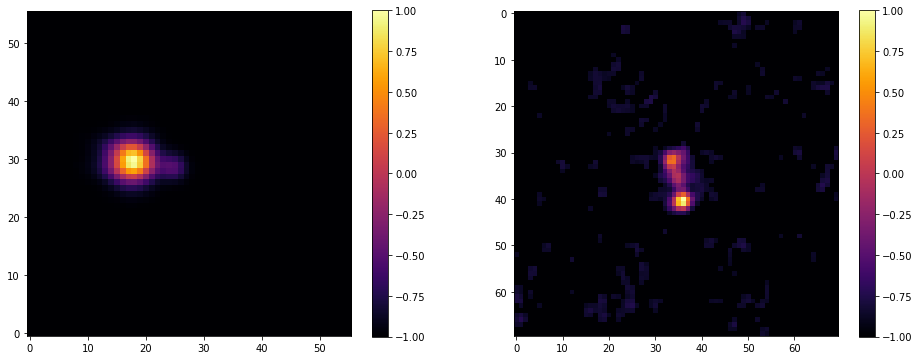

In [103]:
def sim_agn(fr_type=1, rot=True):
    
    dim = 56 # image dimension
    
    # Random variables
    cent_x, cent_y = np.random.normal(dim//2, scale=3, size=2) # black hole location
    angle = np.random.rand()*np.pi
    c1 = np.random.rand()*0.5+0.8
    ratio = np.random.rand()*1.2+1
    c2 = c1*ratio
    
    if fr_type==1:
        d = np.random.rand()*(dim/2)*0.2 + 4 # distance of jets centre from black hole
        tail_halo_sigma = np.random.rand()*2.5
        tail_halo_brightness = np.random.rand()
    if fr_type==2:
        d = np.random.rand()*(dim/2)*0.5 + 4 # distance of jets centre from black hole
        tail_halo_sigma = np.random.rand()*4+1
        tail_halo_brightness = np.random.rand()
    halo_kw = [tail_halo_sigma, tail_halo_sigma, 0, tail_halo_brightness]
    
    # tail locations
    tail1_x = cent_x - d
    tail1_y = cent_y
    tail2_x = cent_x + d*np.cos(angle)
    tail2_y = cent_y + d*np.sin(angle)
    
    # Create blank image and add black hole and tails at calculated coords
    image = np.zeros((dim, dim))
    A = np.random.rand(1)+0.5
    image = add_asym_gauss(image, tail1_x, tail1_y, 1.5, 2.5, (-1)**fr_type*(-np.pi/2), A, c1, c2)
    image = add_asym_gauss(image, tail2_x, tail2_y, 1.5, 2.5, (-1)**fr_type*(np.pi/2)-angle, A+np.random.normal(0,0.1), c1, c2)
    image = add_gauss(image, cent_x, cent_y, 1.5, 1.5, 0, np.random.rand())
    image = add_gauss(image, tail1_x, tail1_y, *halo_kw)
    image = add_gauss(image, tail2_x, tail2_y, *halo_kw)
    #image = add_noise(image)
    image = normalise(image)
    if rot: image = rotate(image, np.random.rand()*360, reshape=False, cval=-1)
    return image, angle*180/np.pi

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 2)
plt.imshow(images[np.random.randint(0,num_images-1)], cmap='inferno')
#plt.axis('off')
plt.colorbar()
plt.subplot(1, 2, 1)
plt.imshow(sim_agn(rot=False)[0], origin='lower', cmap='inferno')
#plt.axis('off')
plt.colorbar()
plt.show()

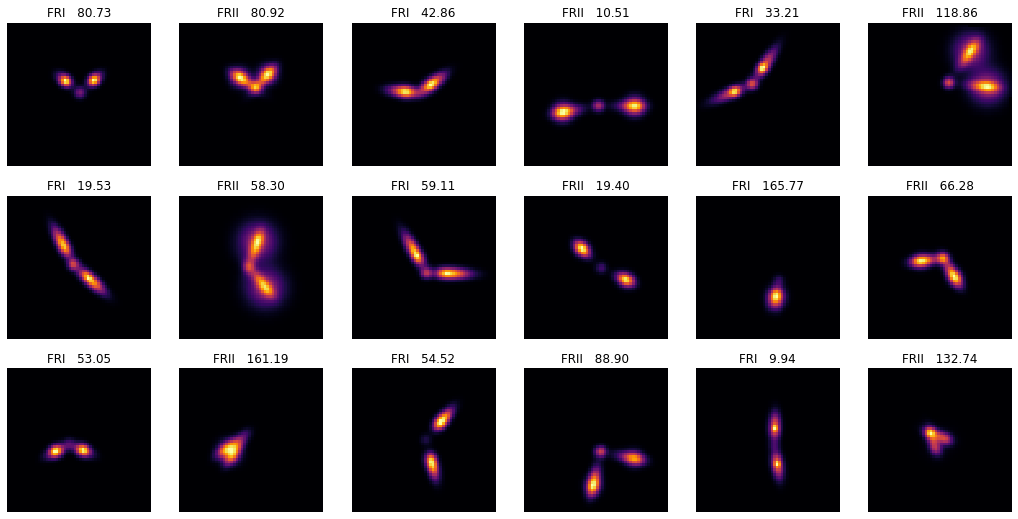

In [104]:
n = 18
synthetic_images1 = np.empty((n, 56, 56))
synthetic_labels1 = np.empty(n)
for i in range(n):
    synthetic_images1[i], synthetic_labels1[i] = sim_agn(i%2+1)

def show_labelled_images(images, labels, num=18, log=False):
    cols = 6
    rows = (num+cols-1)//cols
    plt.figure(figsize=(18,3*rows))
    for i in range(num):
        ax = plt.subplot(rows, cols, i+1)
        image = images[i]
        if log: 
            image = image-np.min(image)+0.01 # make all pixel values positive for log color scale
            plt.imshow(image, cmap='inferno', norm=colors.LogNorm())
        else:
            plt.imshow(image, cmap='inferno')
        type=['FRI', 'FRII']
        plt.title('{}   {:.2f}'.format(type[i%2], labels[i]))
        plt.axis('off')
    plt.show()
    
show_labelled_images(synthetic_images1, synthetic_labels1)

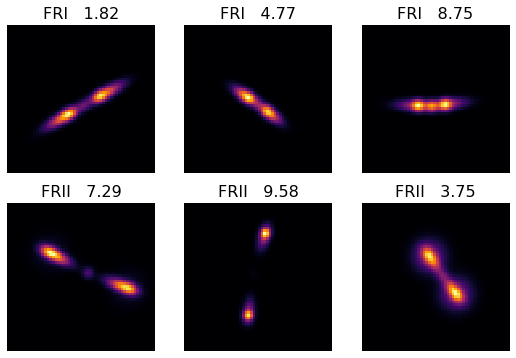

In [107]:
idxs = [2, 4, 16, 11, 1, 3]

def show_labelled_images(images, labels, num=6, log=False):
    cols = 3
    rows = (num+cols-1)//cols
    plt.figure(figsize=(9,3*rows))
    for n, i in enumerate(idxs):
        ax = plt.subplot(rows, cols, n+1)
        image = images[i]
        if log: 
            image = image-np.min(image)+0.01 # make all pixel values positive for log color scale
            plt.imshow(image, cmap='inferno', norm=colors.LogNorm())
        else:
            plt.imshow(image, cmap='inferno')
        type=['FRI', 'FRII']
        plt.title('{}   {:.2f}'.format(type[i%2], labels[i]), fontsize=16)
        plt.axis('off')
    plt.savefig('geo_sim.png')
    plt.show()
    
show_labelled_images(synthetic_images, synthetic_labels)

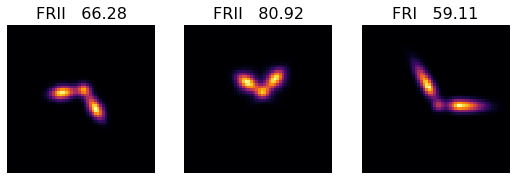

In [108]:
idxs = [11, 1, 8]

def show_labelled_images(images, labels, num=6, log=False):
    cols = 3
    rows = (num+cols-1)//cols
    plt.figure(figsize=(9,3*rows))
    for n, i in enumerate(idxs):
        ax = plt.subplot(rows, cols, n+1)
        image = images[i]
        if log: 
            image = image-np.min(image)+0.01 # make all pixel values positive for log color scale
            plt.imshow(image, cmap='inferno', norm=colors.LogNorm())
        else:
            plt.imshow(image, cmap='inferno')
        type=['FRI', 'FRII']
        plt.title('{}   {:.2f}'.format(type[i%2], labels[i]), fontsize=16)
        plt.axis('off')
    plt.savefig('geo_sim2.png')
    plt.show()
    
show_labelled_images(synthetic_images1, synthetic_labels1)